In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install face_recognition
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_vggface
!pip install keras_applications
!pip install keras==2.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=24c156f93a60afac149ca144131fcceb46ee295f1c2a97e5021292df67af3fdf
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models
  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-u27j8oxj
  Running command git clone --filter=blob:none --quiet https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-u27j8oxj
  Resolved https://github.com/rcmalli/keras-vggface.git to commit bee35376e76e35d00aeec503f2f242611a97b38a
  Preparing metadata (setup.py) ... done
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8294 sha256=33be9a964482769bb3f4758c09ed9289198bc1a0538b7baffffca1bf300f12b2
  Stored in

In [3]:
import os
os.chdir('/content/drive/MyDrive/DeepLearning/Research/Face_Recognition') # Chỉ định nơi làm việc (terminal)

In [32]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, GlobalAveragePooling2D, Dropout

from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model , load_model
from keras.optimizers import Adam , RMSprop , SGD
from keras_vggface.vggface import VGGFace
from keras.callbacks import ModelCheckpoint

import tensorflow as tf
import face_recognition
import cv2
import pickle
from PIL import Image
from keras_vggface import utils

import random
from imutils import paths
from sklearn.preprocessing import LabelEncoder

from datetime import datetime

#### Chuẩn bị dữ liệu để Transfer learning : Fine tuning

- Load ra các ảnh trong các folder nhãn
- Phát hiện khuông mặt trong các ảnh đó bằng faces = face_recognition.face_locations(imagetest) sau đó resize lại thành 224*224
- Lưu ảnh khuông mặt được phát hiện lại

- Folder Dataset_fine_tuning_train_valid_test có các folder train , test , valid và các folder label ở trong đó
- Tổ chức folder tương tự trong Dataset_face_fine_tuning_train_valid_test bằng code và lưu các ảnh khuông mặt trích xuất được vào đó
- Lưu ý một số ảnh có khuông mặt người lạ vào thì nên kiểm tra lại rồi xóa đi tránh làm cho model bị giảm độ chính xác (ví dụ label 'Tri')

In [13]:
# Đường dẫn tới các thư mục chứa dataset gốc và dataset mới
dataset_root = "./Dataset_fine_tuning_train_valid_test"
new_dataset_root = "./Dataset_face_fine_tuning_train_valid_test"

# Tạo thư mục mới nếu chưa tồn tại
for folder in ['train', 'test', 'valid']:
    os.makedirs(os.path.join(new_dataset_root, folder), exist_ok=True)

# Lặp qua các thư mục trong dataset gốc (train, test, valid)
for folder_name in os.listdir(dataset_root):
    # Đường dẫn tới thư mục hiện tại trong dataset gốc và trong dataset mới
    original_folder_path = os.path.join(dataset_root, folder_name)
    new_folder_path = os.path.join(new_dataset_root, folder_name)

    # lặp qua các folder label
    for folder_label in os.listdir(original_folder_path):
        # Đường dẫn tới thư mục hiện tại trong dataset gốc và trong dataset mới
        folder_label_path = os.path.join(original_folder_path, folder_label)
        # Tạo thư mục label mới nếu chưa tồn tại
        new_label_path = os.path.join(new_folder_path, folder_label)
        os.makedirs(new_label_path, exist_ok=True)

        # Lặp qua các tệp trong thư mục hiện tại
        for filename in os.listdir(folder_label_path):
            # Đường dẫn tới tệp ảnh hiện tại
            image_path = os.path.join(folder_label_path, filename)

            # Load ảnh và phát hiện khuôn mặt
            imagetest = face_recognition.load_image_file(image_path)
            imagetest = cv2.cvtColor(imagetest, cv2.COLOR_BGR2RGB)
            faces = face_recognition.face_locations(imagetest)

            # Nếu không phát hiện được khuôn mặt, tiếp tục với ảnh khác
            if len(faces) == 0:
                continue

            # Lưu khuôn mặt vào thư mục mới
            for (y1, x2, y2, x1) in faces:
                # Vùng khuôn mặt được phát hiện & resize kích thước vùng khuôn mặt thành 224x224
                roi = imagetest[y1:y2, x1:x2]
                resized_image = cv2.resize(roi, (224, 224))

                # Lưu khuôn mặt vào thư mục mới với tên là số thứ tự
                new_image_path = os.path.join(new_label_path, f"{len(os.listdir(new_label_path)) + 1}.jpg")
                cv2.imwrite(new_image_path, resized_image)


Sau khi có được tập ảnh thì ta tiến hành chuyển ảnh sang dạng tensor và traning

In [5]:
root_dir = './Dataset_face_fine_tuning_train_valid_test'
train_dir = os.path.join(root_dir, 'train')
val_dir = os.path.join(root_dir, 'valid')
test_dir = os.path.join(root_dir, 'test')

In [11]:
img_size = (224 , 224) # resize về đúng kích thước mà VGGFace SENet cần là (224,224)
batch_size = 8
img_shape = (img_size[0] , img_size[1] , 3)

# làm giàu dữ liệu data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)  # Chỉ rescale cho dữ liệu kiểm tra
# làm giàu dữ liệu data augmentation

train_gen = train_datagen.flow_from_directory(train_dir , target_size = img_size , class_mode = 'categorical' ,
                                       color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

valid_gen = test_datagen.flow_from_directory(val_dir , target_size = img_size , class_mode = 'categorical' ,
                                       color_mode = 'rgb' , shuffle = True , batch_size = batch_size)

test_gen = test_datagen.flow_from_directory(test_dir , target_size = img_size , class_mode = 'categorical' ,
                                       color_mode = 'rgb' , shuffle = False , batch_size = batch_size)

Found 142 images belonging to 17 classes.
Found 43 images belonging to 17 classes.
Found 27 images belonging to 17 classes.


In [19]:
# Lấy ra danh sách nhãn từ train_gen
name_classes = list(train_gen.class_indices.keys())
print(name_classes)
print(len(name_classes))

['Can', 'Cuong', 'Dat', 'Hung', 'Huy', 'Lich', 'Long', 'Manh', 'Nghia', 'Phuc', 'Quoc', 'Thai', 'Thuan', 'Toan', 'Tri', 'Tu', 'Tung']
17


Show Sample From Train Data

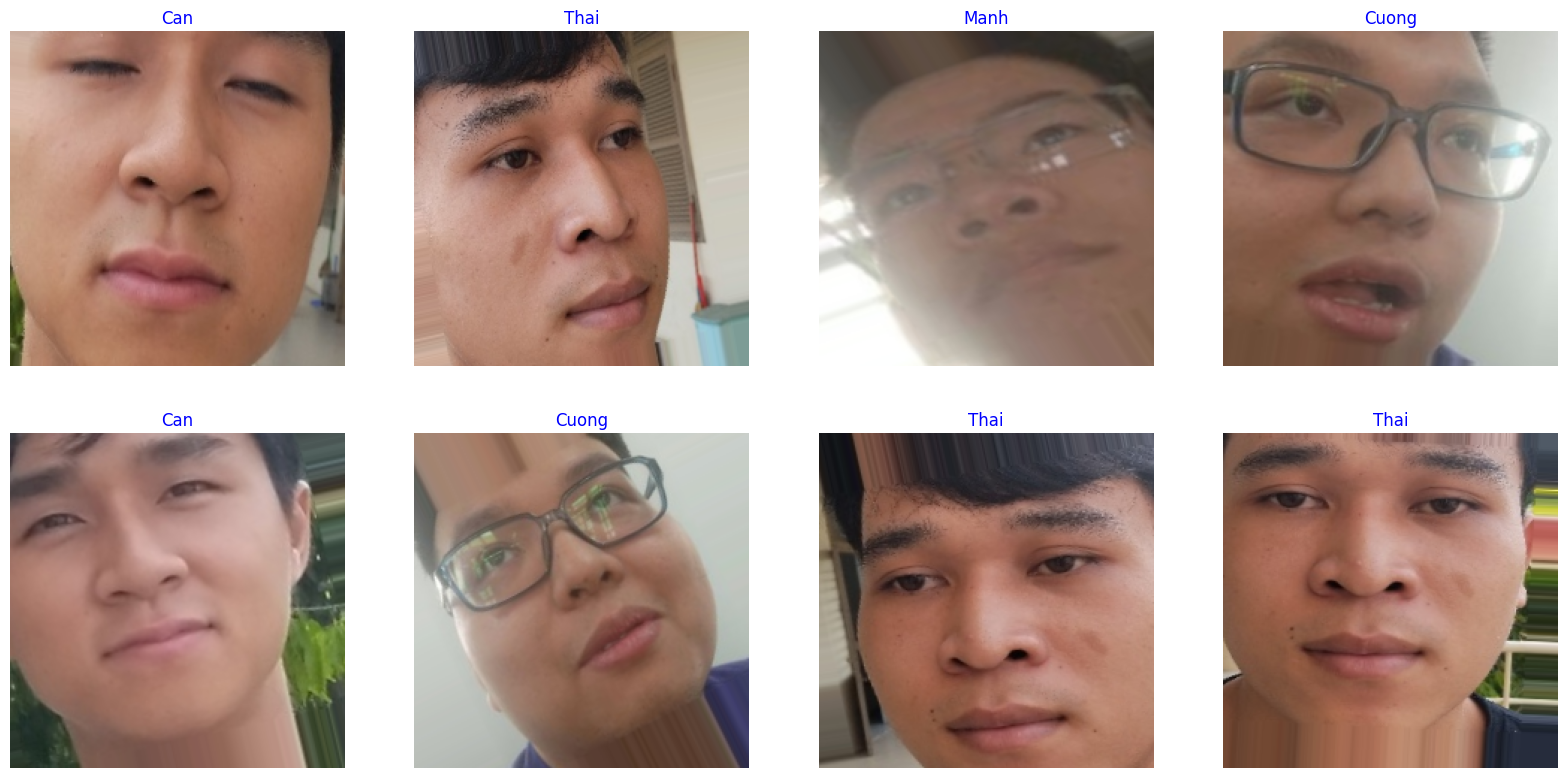

In [7]:
g_dict = train_gen.class_indices
classes = list(g_dict.keys())
images, labels = next(train_gen)
num_samples = len(images)

plt.figure(figsize=(20, 20))

for i in range(min(16, num_samples)):
    plt.subplot(4, 4, i + 1)
    image = images[i] # Không cần chia lại cho 255
    plt.imshow(image)
    class_index = np.argmax(labels[i]) # Lấy index của nhãn cao nhất
    class_name = classes[class_index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

#### VGG Face SENet50 - Transfer learning - Fine tuning

- Ngay từ ban đầu ta đã xác định là : Transfer learning Feature Extractor dành cho bài toán có nhãn thay đổi .
- Ta sẽ Transfer learning : Fine tuning VGG Face để kết hợp tập image face của mô hình train sẵn và tập dữ liệu của ta .
- Dù số nhãn thay đổi , nhưng vì để traning được model , ta vẫn phải thêm vào lớp softmax ở cuối khi Fine tuning
- Sau khi đã thu được model ta vẫn có thể load ra rồi bỏ đi lớp softmax ở cuối để trích xuất vector đặc trưng của khuông mặt  

##### Lưu ý : Cách làm này chỉ hoạt động tốt khi ta có tập dữ liệu để transfer lại lớn , nếu tập dữ liệu nhỏ thì sẽ dễ dẫn đến overfiting

In [55]:
base_model = VGGFace(include_top=False,model='senet50',input_shape=(224, 224, 3))
myFCHead = base_model.output # (None, 1, 1, 2048) # lớp cuối của Conv VGGFace
myFCHead = GlobalAveragePooling2D()(myFCHead) # flatten # Cách 1 # làm phẳng
# myFCHead = Flatten(name='flatten')(myFCHead) # 1x1x2048 = 2048 # Cách 2
myFCHead = Dense(1024, activation='relu')(myFCHead)
myFCHead = Dense(512, activation='relu')(myFCHead)
myFCHead = Dense(256, activation='relu')(myFCHead)
myFCHead = Dense(128, activation='relu')(myFCHead)
myFCHead = Dense(len(name_classes), activation='softmax')(myFCHead)

myModel = Model(inputs=base_model.input, outputs=myFCHead)
# myModel.summary()

In [56]:
# freeze VGG model
for layer in base_model.layers:
    layer.trainable = False

# thuật toán tối ưu
# optimizer = tf.keras.optimizers.Adam()
optimizer = RMSprop(0.001)
myModel.compile(optimizer, 'categorical_crossentropy', metrics=['accuracy'])

numOfEpoch = 10
H = myModel.fit(
    train_gen,
    steps_per_epoch= train_gen.n // batch_size,
    validation_data=valid_gen,
    validation_steps= valid_gen.n // batch_size,
    epochs=numOfEpoch,
)

Epoch 1/10
17/17 [==============================] - 9s 280ms/step - loss: 3.6985 - accuracy: 0.1567 - val_loss: 2.8168 - val_accuracy: 0.1000
Epoch 2/10
17/17 [==============================] - 2s 140ms/step - loss: 2.8559 - accuracy: 0.0522 - val_loss: 2.7906 - val_accuracy: 0.0750
Epoch 3/10
17/17 [==============================] - 3s 182ms/step - loss: 2.7916 - accuracy: 0.0970 - val_loss: 2.8229 - val_accuracy: 0.1000
Epoch 4/10
17/17 [==============================] - 3s 170ms/step - loss: 2.8141 - accuracy: 0.0821 - val_loss: 2.7834 - val_accuracy: 0.1000
Epoch 5/10
17/17 [==============================] - 3s 191ms/step - loss: 2.7858 - accuracy: 0.0896 - val_loss: 2.7624 - val_accuracy: 0.0750
Epoch 6/10
17/17 [==============================] - 2s 146ms/step - loss: 2.7726 - accuracy: 0.0970 - val_loss: 2.7613 - val_accuracy: 0.1000
Epoch 7/10
17/17 [==============================] - 2s 134ms/step - loss: 2.8228 - accuracy: 0.0672 - val_loss: 2.7913 - val_accuracy: 0.1000
Epoch 

In [57]:
# unfreeze some last CNN layer:
for layer in base_model.layers[5:]:
    layer.trainable = True

save_best_only = True
checkpoint = ModelCheckpoint('./save_models/myVGGFace_SENet50_Transfer_Fine_Tuning_model-{epoch:03d}.keras',
                             monitor='accuracy', # val_loss
                             verbose=1,
                             save_best_only=save_best_only,
                             mode='auto')

numOfEpoch = 30
optimizer = SGD(0.001)
myModel.compile(optimizer, 'categorical_crossentropy', metrics=['accuracy']) # ta có thể ghi optimizer = optimizer, hoặc optimizer là nó tự hiểu

H = myModel.fit(
    train_gen,
    steps_per_epoch= train_gen.n // batch_size,
    validation_data = valid_gen,
    validation_steps= valid_gen.n // batch_size,
    epochs=numOfEpoch,
    callbacks=[checkpoint]
)

Epoch 1/30
17/17 [==============================] - ETA: 0s - loss: 2.7150 - accuracy: 0.1618
Epoch 1: accuracy improved from -inf to 0.16176, saving model to ./save_models/myVGGFace_SENet50_Transfer_Fine_Tuning_model-001.keras
17/17 [==============================] - 12s 294ms/step - loss: 2.7150 - accuracy: 0.1618 - val_loss: 2.7840 - val_accuracy: 0.0750
Epoch 2/30
17/17 [==============================] - ETA: 0s - loss: 2.4209 - accuracy: 0.2910
Epoch 2: accuracy improved from 0.16176 to 0.29104, saving model to ./save_models/myVGGFace_SENet50_Transfer_Fine_Tuning_model-002.keras
17/17 [==============================] - 5s 267ms/step - loss: 2.4209 - accuracy: 0.2910 - val_loss: 3.0259 - val_accuracy: 0.0750
Epoch 3/30
17/17 [==============================] - ETA: 0s - loss: 2.1544 - accuracy: 0.4179
Epoch 3: accuracy improved from 0.29104 to 0.41791, saving model to ./save_models/myVGGFace_SENet50_Transfer_Fine_Tuning_model-003.keras
17/17 [==============================] - 4s 207

In [58]:
myModel.save('./save_models/myVGGFace_SENet50_Transfer_Fine_Tuning_model_epoch_30.keras')

#### Một số đoạn code Visualization (đọc thêm)

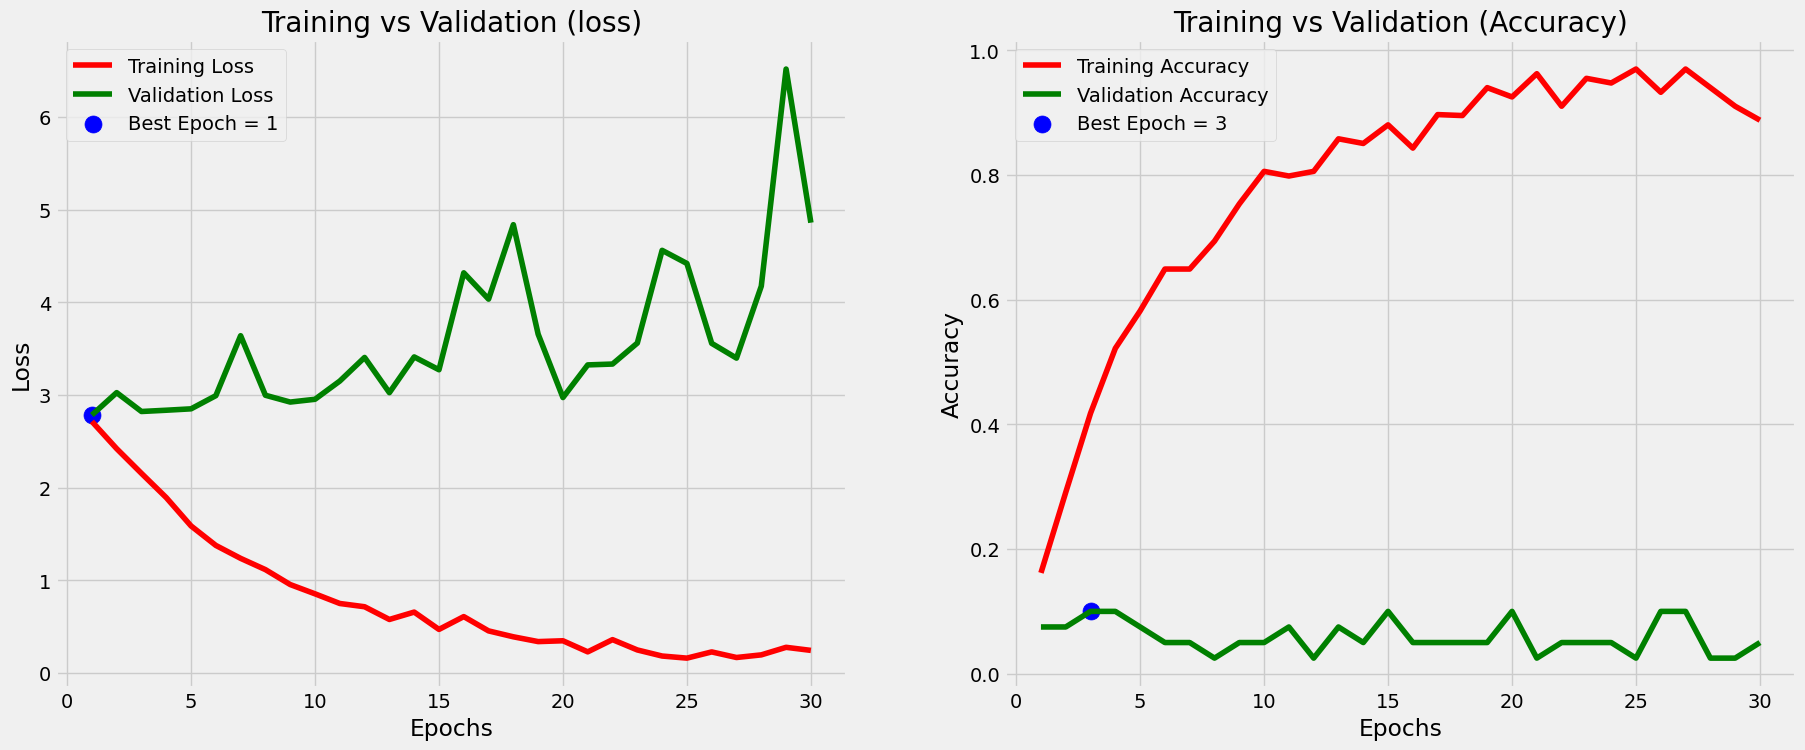

In [59]:
train_acc = H.history['accuracy']
train_loss = H.history['loss']

val_acc = H.history['val_accuracy']
val_loss = H.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r', label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss +1 , val_lowest , s = 150 , c = 'blue' , label = loss_label)
plt.title('Training vs Validation (loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r', label= 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s= 150 , c = 'blue' , label= acc_label)
plt.title('Training vs Validation (Accuracy)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [60]:
from keras.models import load_model
Model_VGGFace_fine_tune = load_model('./save_models/myVGGFace_SENet50_Transfer_Fine_Tuning_model-025.keras')

train_score = myModel.evaluate(train_gen , steps= 32 , verbose = 1)
val_score = myModel.evaluate(valid_gen , steps = 32 , verbose = 1)
test_score = myModel.evaluate(test_gen , steps = 32 , verbose = 1)

print(f'Train loss = {train_score[0] }')
print(f'Train Accuracy = {train_score[1]}')
print(f'Validation loss = {val_score[0]}')
print(f'Validation Accuracy = {val_score[1]}')
print(f'Test loss = {test_score[0]}')
print(f'Test Accuracy = {test_score[1]}')

18/32 [===============>..............] - ETA: 1s - loss: 4.7387 - accuracy: 0.0493

 5/32 [===>..........................] - ETA: 1s - loss: 4.7386 - accuracy: 0.0500

 3/32 [=>............................] - ETA: 1s - loss: 4.7652 - accuracy: 0.0417    

32/32 [==============================] - 0s 4ms/step - loss: 4.8344 - accuracy: 0.0370
Train loss = 4.738715648651123
Train Accuracy = 0.04929577559232712
Validation loss = 4.841901779174805
Validation Accuracy = 0.04651162773370743
Test loss = 4.834441184997559
Test Accuracy = 0.03703703731298447


Theo như kết quả trên cho thấy thì model đã overfitting

In [62]:
from sklearn.metrics import classification_report, confusion_matrix

# Dự đoán
preds = myModel.predict(test_gen)
preds = np.argmax(preds, axis=1)

# Lấy nhãn thật
true_labels = test_gen.classes

# Tính các chỉ số
report = classification_report(true_labels, preds, output_dict=True)

# In chỉ số f1, precision, recall
print("F1:", report['weighted avg']['f1-score'])
print("Precision:", report['weighted avg']['precision'])
print("Recall:", report['weighted avg']['recall'])

4/4 [==============================] - 2s 49ms/step
F1: 0.0026455026455026454
Precision: 0.0013717421124828531
Recall: 0.037037037037037035


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
print(classification_report(true_labels, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         2
           7       0.04      1.00      0.07         1
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         1

    accuracy                           0.04        27
   macro avg       0.00   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
# Tính confusion matrix
conf_mat = confusion_matrix(true_labels, preds)

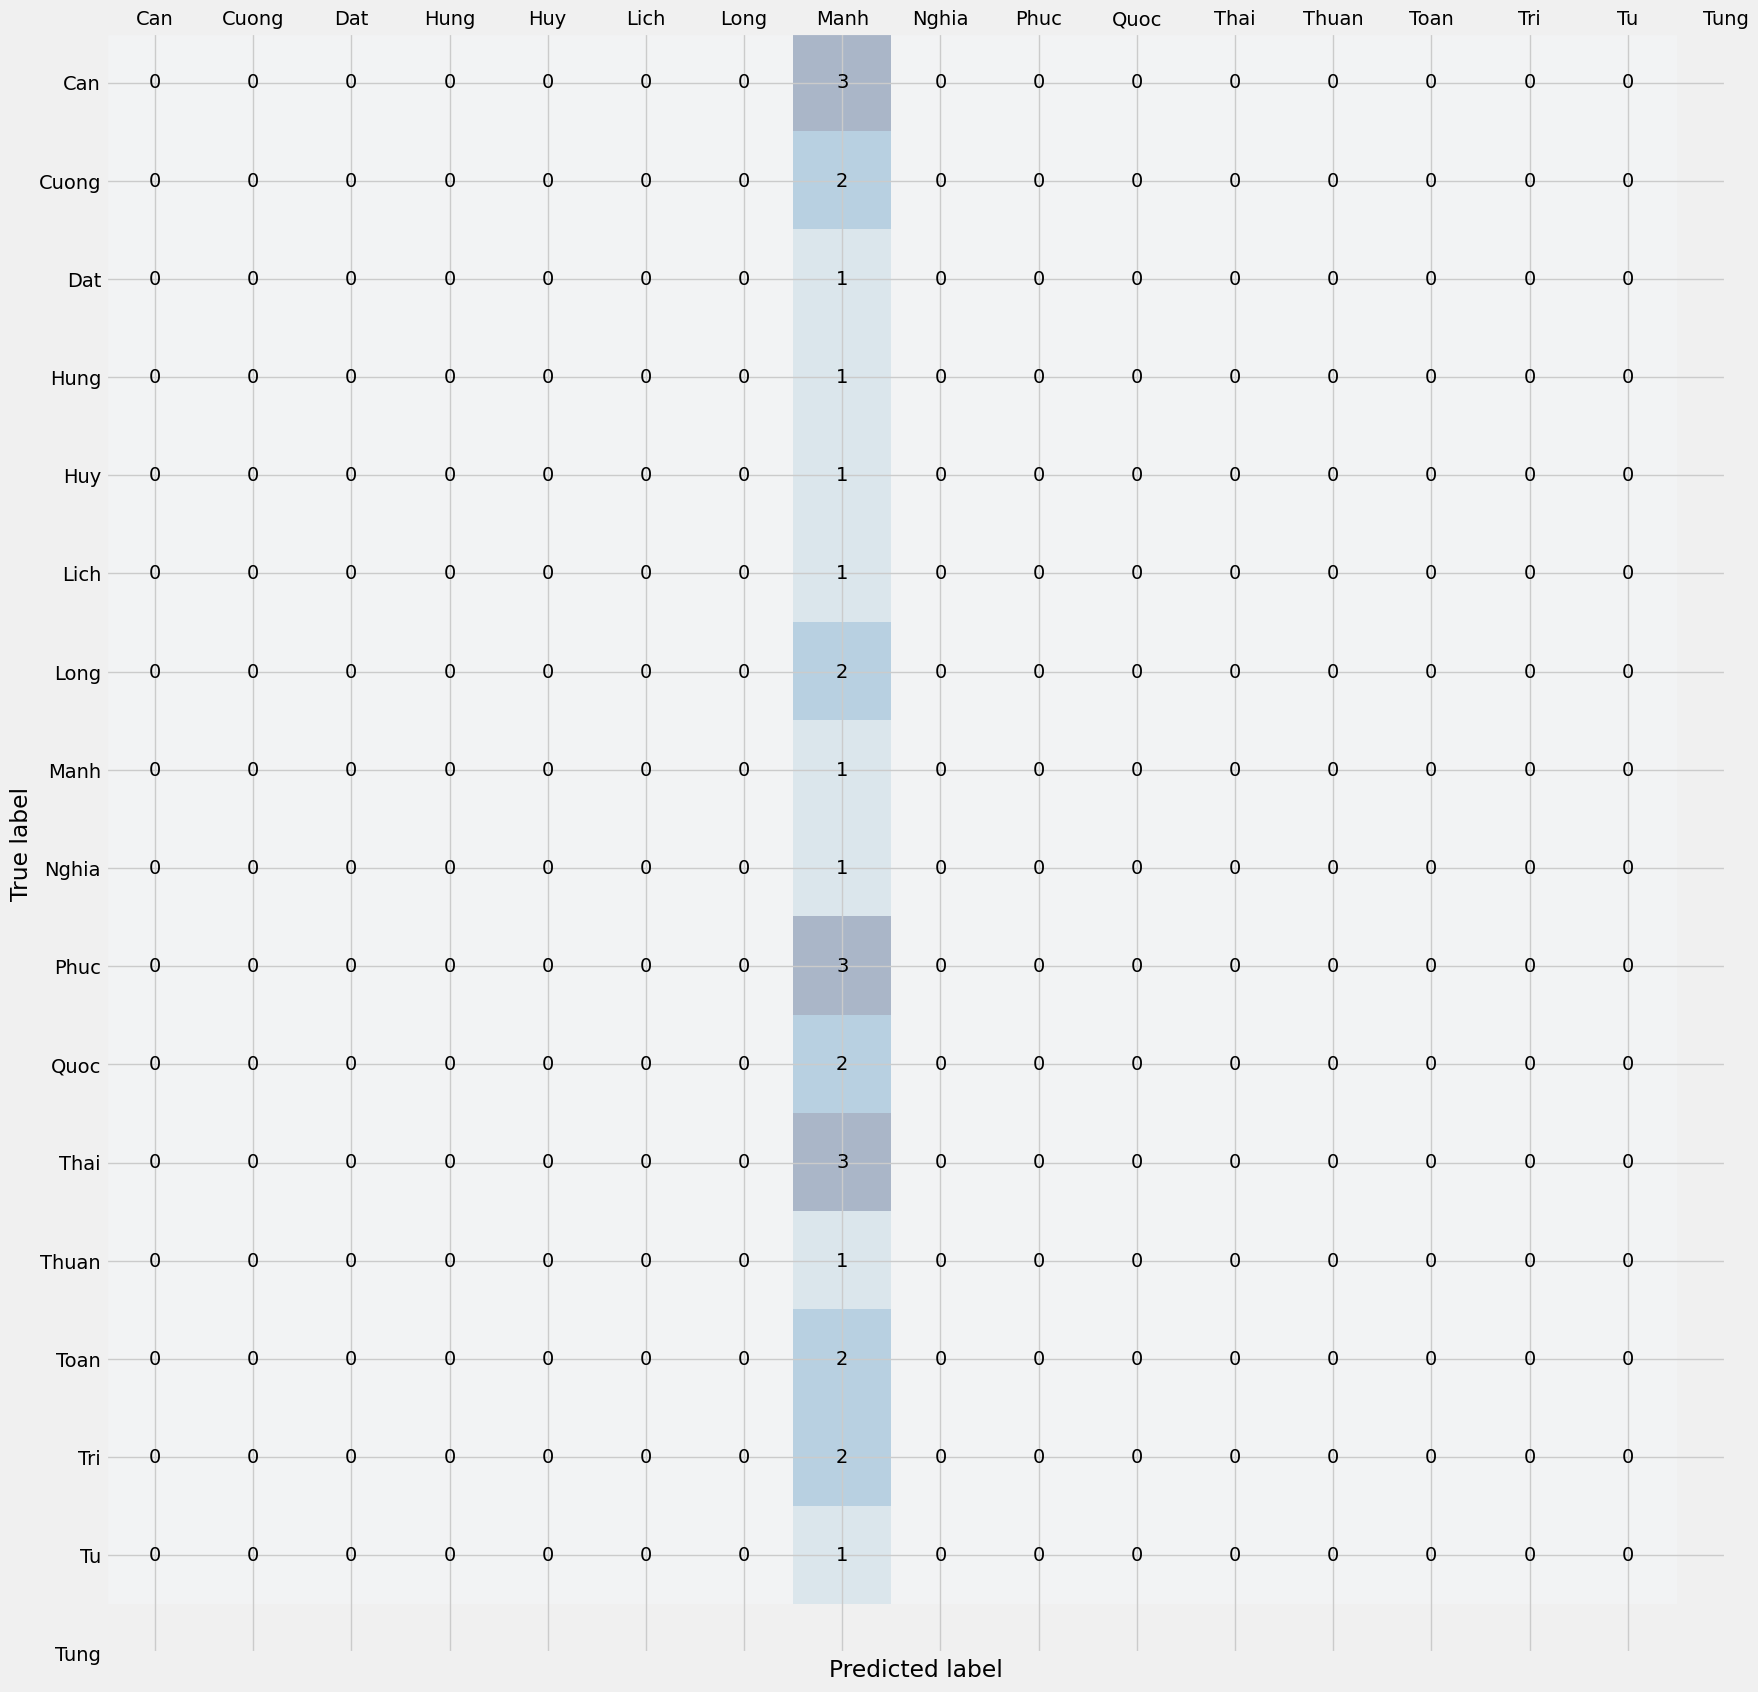

In [66]:
fig, ax = plt.subplots(figsize=(20,20))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)

# Hiển thị các nhãn trên trục Ox và Oy
ax.set_xticks(np.arange(len(name_classes)))
ax.set_yticks(np.arange(len(name_classes)))
ax.set_xticklabels(name_classes)
ax.set_yticklabels(name_classes)

# Hiển thị giá trị của ma trận nhầm lẫn trong từng ô
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i,j], va='center', ha='center')

# Đặt tiêu đề và nhãn cho trục Ox và Oy
plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.show()